## Creating a logistic regression model in Python!

In [2]:
# Reference: https://github.com/susanli2016/Machine-Learning-with-Python/blob/master/Logistic%20Regression%20balanced.ipynb

### Import necessary libraries:

In [3]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt 
plt.rc("font", size=14) 

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from mpl_toolkits.basemap import Basemap


import os
import datetime
import pytz
import re

import peakutils
import statsmodels.api as sm

import requests

#Read data from a local csv file:

##Will change this to scrape files from the Smartfin.org website later.
#data = pd.read_csv('Motion_13735.CSV', header=0)   
#data = data.dropna()

#Print out the column headings:
#print(data.shape)
#print(list(data.columns))

### Summary of specific ride IDs:

In [4]:
ride_ids = ['15692']


#ride_ids = ['14827']
# 14743 - Motion Control July 10th
# 14750 - Magnetometer Control July 11th
# 14814 - Pool Displacement Control July 17th
# 14815 - Compass Orientation (Lying on Charger Side) July 19th
# 14816 - Orientation w Higher Sampling (Lying on Charger Side) July 20th
# 14827 - Pool Displacement Control w Higher Sampling (Jul 23)
# 14888 - First Buoy Calibration Experiment (July 30)
# 15218 - Jasmine's Second Ride Sesh filmed with GoPro (Aug 29) //no footage
# 15629 - Jasmine's First Ride Sesh filmed with VIRB (Oct. 24) //first labelled footage!
# 15669 - Jasmine's Second Ride Sesh filmed with VIRB (Nov. 7) //second labelled footage!


## Fin ID Scraper (pulls dataframes for specific ride id from website):

In [5]:
#%% Fin ID scraper
# Input fin ID, get all ride IDs
# base URL to which we'll append given fin IDs
fin_url_base = 'http://surf.smartfin.org/fin/'

# Look for the following text in the HTML contents in fcn below
str_id_ride = 'rideId = \'' # backslash allows us to look for single quote
str_id_date = 'var date = \'' # backslash allows us to look for single quote

#%% Ride ID scraper
# Input ride ID, get ocean and motion CSVs
# Base URL to which we'll append given ride IDs
ride_url_base = 'https://surf.smartfin.org/ride/'

# Look for the following text in the HTML contents in fcn below
str_id_csv = 'img id="temperatureChart" class="chart" src="' 

def get_csv_from_ride_id(rid):
    # Build URL for each individual ride
    ride_url = ride_url_base+str(rid)
    print(ride_url)
    
    # Get contents of ride_url
    html_contents = requests.get(ride_url).text
    
    # Find CSV identifier 
    loc_csv_id = html_contents.find(str_id_csv)
    
    # Different based on whether user logged in with FB or Google
    offset_googleOAuth = [46, 114]
    offset_facebkOAuth = [46, 112]
    if html_contents[loc_csv_id+59] == 'f': # Facebook login
        off0 = offset_facebkOAuth[0]
        off1 = offset_facebkOAuth[1]
    else: # Google login
        off0 = offset_googleOAuth[0]
        off1 = offset_googleOAuth[1]
        
    csv_id_longstr = html_contents[loc_csv_id+off0:loc_csv_id+off1]
    
#    print(csv_id_longstr)
    
    # Stitch together full URL for CSV
    if ("media" in csv_id_longstr) & ("Calibration" not in html_contents): # other junk URLs can exist and break everything
        
        ocean_csv_url = 'https://surf.smartfin.org/'+csv_id_longstr+'Ocean.CSV'
        motion_csv_url = 'https://surf.smartfin.org/'+csv_id_longstr+'Motion.CSV'
        
        print(ocean_csv_url)
        # Go to ocean_csv_url and grab contents (theoretically, a CSV)
        ocean_df_small = pd.read_csv(ocean_csv_url, parse_dates = [0])
        elapsed_timedelta = (ocean_df_small['UTC']-ocean_df_small['UTC'][0])
        ocean_df_small['elapsed'] = elapsed_timedelta/np.timedelta64(1, 's')
        
        motion_df_small = pd.read_csv(motion_csv_url, parse_dates = [0])
        
        # Reindex on timestamp if there are at least a few rows
        if len(ocean_df_small) > 1:
            ocean_df_small.set_index('UTC', drop = True, append = False, inplace = True)
            motion_df_small.set_index('UTC', drop = True, append = False, inplace = True)
            
            #print(ocean_df_small)
            #print(motion_df_small)
            
            #May need to change this sampling interval:
            sample_interval = '33ms'
            
            
            ocean_df_small_resample = ocean_df_small.resample(sample_interval).mean()
            motion_df_small_resample = motion_df_small.resample(sample_interval).mean()
            
            # No need to save many extra rows with no fix
            motion_df_small = motion_df_small[~np.isnan(motion_df_small.Latitude)]
            
            return ocean_df_small_resample, motion_df_small_resample

    else:
        ocean_df_small_resample = pd.DataFrame() # empty DF just so something is returned
        motion_df_small_resample = pd.DataFrame() 
        return ocean_df_small_resample, motion_df_small_resample
    
appended_ocean_list = [] # list of DataFrames from original CSVs
appended_motion_list = []
appended_multiIndex = [] # fin_id & ride_id used to identify each DataFrame

## Nested loops (for each fin ID, find all ride IDs, then build a DataFrame from all ride CSVs)
## (Here, ride IDS are either ocean or motion dataframes)
count_good_fins = 0
    
# Loop over ride_ids and find CSVs
for rid in ride_ids:
    try:
        new_ocean_df, new_motion_df = get_csv_from_ride_id(rid) # get given ride's CSV from its ride ID using function above
        #print(len(new_ocean_df))
        #print(len(new_motion_df))
        if not new_ocean_df.empty: # Calibration rides, for example
            # Append only if DF isn't empty. There may be a better way to control empty DFs which are created above
            appended_multiIndex.append(str(rid)) # build list to be multiIndex of future DataFrame
            appended_ocean_list.append(new_ocean_df)
            appended_motion_list.append(new_motion_df)
            print("Ride data has been uploaded.")
            #print("Ride: ", rid, "data has been uploaded.")
            count_good_fins += 1
        
    except: 
        print("Ride threw an exception!")
        #print("Ride ", rid, "threw an exception!")    

#%% Build the "Master" DataFrame

# appended_ocean_df.summary()
df_keys = tuple(appended_multiIndex) # keys gotta be a tuple, a list which data in it cannot be changed
ocean_df = pd.concat(appended_ocean_list, keys = df_keys, names=['ride_id'])
motion_df = pd.concat(appended_motion_list, keys = df_keys, names = ['ride_id'])


##Here, maybe just use info from the motion_df and don't worry about ocean_df data for now.
##If you do want ocean_df data, look at how Phil was getting it from "July 10th and 11th Calibration" jupyter notebook file.

#We can also check to see if the surfboard was recording "in-water-freq" or 
#"out-of-water-freq" based on how many NaN values we see. 
print(motion_df)

https://surf.smartfin.org/ride/15692
https://surf.smartfin.org/media/201811/google_105349665704999793400_0006667E229D_181109191556_Ocean.CSV
Ride data has been uploaded.
                                         Time  IMU A1  IMU A2  IMU A3  IMU G1  \
ride_id UTC                                                                     
15692   2018-11-09 19:16:03.789  1.414743e+09   493.0    48.0   110.0    75.0   
        2018-11-09 19:16:03.822           NaN     NaN     NaN     NaN     NaN   
        2018-11-09 19:16:03.855           NaN     NaN     NaN     NaN     NaN   
        2018-11-09 19:16:03.888           NaN     NaN     NaN     NaN     NaN   
        2018-11-09 19:16:03.921           NaN     NaN     NaN     NaN     NaN   
        2018-11-09 19:16:03.954           NaN     NaN     NaN     NaN     NaN   
        2018-11-09 19:16:03.987           NaN     NaN     NaN     NaN     NaN   
        2018-11-09 19:16:04.020           NaN     NaN     NaN     NaN     NaN   
        2018-11-09 1

## Drop the NA values from the dataframe:

In [6]:
#Drop the latitude and longitude values since most of them are Nan:
motion_df_dropped = motion_df.drop(columns=['Latitude', 'Longitude'])


#Drop the NAN values from the motion data:
motion_df_dropped = motion_df_dropped.dropna(axis=0, how='any')
print(motion_df_dropped)

                                         Time  IMU A1  IMU A2  IMU A3  IMU G1  \
ride_id UTC                                                                     
15692   2018-11-09 19:16:03.789  1.414743e+09   493.0    48.0   110.0    75.0   
        2018-11-09 19:16:04.053  1.414743e+09   513.0    89.0    62.0    34.0   
        2018-11-09 19:16:04.284  1.414743e+09   494.0    92.0    80.0    69.0   
        2018-11-09 19:16:04.548  1.414744e+09   421.0   205.0  -104.0   192.0   
        2018-11-09 19:16:04.812  1.414744e+09   534.0   306.0   -32.0  -421.0   
        2018-11-09 19:16:05.043  1.414744e+09   455.0   149.0  -102.0  -355.0   
        2018-11-09 19:16:05.307  1.414744e+09   474.0   342.0  -219.0  -234.0   
        2018-11-09 19:16:05.571  1.414745e+09   363.0   323.0  -131.0    60.0   
        2018-11-09 19:16:05.802  1.414745e+09   -21.0   510.0  -447.0    78.0   
        2018-11-09 19:16:06.066  1.414745e+09    35.0   283.0  -132.0  -114.0   
        2018-11-09 19:16:06.

## Create an elapsed time field to sync Smartfin data with Video Footage:

In [7]:
#Create an elapsed_timedelta field:

#timedelta_values = (motion_df_dropped['Time']-motion_df_dropped['Time'][0])
#motion_df_dropped.insert(loc=1, column='TimeDelta', value=timedelta_values, drop=True)
motion_df_dropped['TimeDelta'] = (motion_df_dropped['Time']-motion_df_dropped['Time'][0])
#print(elapsed_timedelta)
#motion_df_dropped.head()
motion_df_dropped.head(10)

Time  IMU A1  IMU A2  IMU A3  IMU G1  \
ride_id UTC                                                                     
15692   2018-11-09 19:16:03.789  1.414743e+09   493.0    48.0   110.0    75.0   
        2018-11-09 19:16:04.053  1.414743e+09   513.0    89.0    62.0    34.0   
        2018-11-09 19:16:04.284  1.414743e+09   494.0    92.0    80.0    69.0   
        2018-11-09 19:16:04.548  1.414744e+09   421.0   205.0  -104.0   192.0   
        2018-11-09 19:16:04.812  1.414744e+09   534.0   306.0   -32.0  -421.0   
        2018-11-09 19:16:05.043  1.414744e+09   455.0   149.0  -102.0  -355.0   
        2018-11-09 19:16:05.307  1.414744e+09   474.0   342.0  -219.0  -234.0   
        2018-11-09 19:16:05.571  1.414745e+09   363.0   323.0  -131.0    60.0   
        2018-11-09 19:16:05.802  1.414745e+09   -21.0   510.0  -447.0    78.0   
        2018-11-09 19:16:06.066  1.414745e+09    35.0   283.0  -132.0  -114.0   

                                 IMU G2  IMU G3  IMU M1  IMU M2  IMU M3  \
ride_id UTC                                                               
15692   2018-11-09 19:16:03.789  -124.0   -86.0  -309.0   209.0    39.0   
        2018-11-09 19:16:04.053   -36.0   -92.0  -320.0   194.0    38.0   
        2018-11-09 19:16:04.284   -63.0   -42.0  -329.0   189.0    49.0   
        2018-11-09 19:16:04.548   -92.0   -37.0  -330.0   180.0    64.0   
        2018-11-09 19:16:04.812  -233.0  -229.0  -325.0   161.0    97.0   
        2018-11-09 19:16:05.043  -376.0  -397.0  -337.0   117.0   151.0   
        2018-11-09 19:16:05.307  -527.0  -465.0  -311.0    25.0   217.0   
        2018-11-09 19:16:05.571  -662.0  -305.0  -238.0    -8.0   272.0   
        2018-11-09 19:16:05.802  -643.0  -153.0  -159.0   -21.0   321.0   
        2018-11-09 19:16:06.066  -430.0   132.0   -86.0   -38.0   326.0   

                                 TimeDelta  
ride_id UTC                                 
15692   2018-11-09 19:16:03.789        0.0  
        2018-11-09 19:16:04.053      252.5  
        2018-11-09 19:16:04.284      501.5  
        2018-11-09 19:16:04.548      753.5  
        2018-11-09 19:16:04.812     1003.5  
        2018-11-09 19:16:05.043     1253.5  
        2018-11-09 19:16:05.307     1504.5  
        2018-11-09 19:16:05.571     1755.5  
        2018-11-09 19:16:05.802     2006.5  
        2018-11-09 19:16:06.066     2258.5

## Footage sync code written by Alina:

In [8]:
#Footage sync code written by Alina:

import time

#simple method: only walking, paddling, floating, surfing
#complex method: columns created based on footage file labels
def label_data( footage_file = 'Footage.txt', labelling_method = 'simple', sync_threshold = 20000 ):
    
    #First, perform sync
    sync_buf = 0
    with open(footage_file) as file:
        for line in file:
            labelled_time = line.split(None, 2) 
            try:
                cur_time = time.strptime(labelled_time[0], '%M:%S')
            except:
                continue
            labelled_time[1] = labelled_time[1].rstrip()
            if labelled_time[1].lower() == 'sync': #Assumption that first word in sync line is "sync"
                sync_time = cur_time.tm_min * 60 * 1000 + cur_time.tm_sec * 1000
                index = 0
                start = 0
                end = 0
                #Syncing occurs when IMU A2 data is negative for a longer period than the provided threshold
                #Default is 20 seconds
                for data in motion_df_dropped['IMU A2']:
                    if data < 0 and start == 0:
                        start = motion_df_dropped['TimeDelta'][index]
                    elif data > 0 and start != 0:
                        end = motion_df_dropped['TimeDelta'][index]
                        if end - start > sync_threshold:
                            sync_buf = start - sync_time
                            break
                        start = 0
                    index += 1

    accepted_labels = set()
    if labelling_method == 'simple':
        accepted_labels = {'WALKING', 'PADDLING', 'FLOATING', 'SURFING'}

        #Create new DataFrame containing label info
        label_frame = pd.DataFrame(0, index = motion_df_dropped.index, columns = accepted_labels)
        for label in accepted_labels:
            label_frame[label] = [0] * len(motion_df_dropped['Time'])
    
    #Convention of labelled footage text: "MINUTE:SECOND LABEL"
    elapsed_time = 0
    cur_label = ''
    buffer = 0
    with open(footage_file) as file:
        for line in file:
            
            if labelling_method == 'simple':
                labelled_time = line.split(None, 2) #simple categorizes on a one-word basis
            else:
                labelled_time = line.split(None, 1) #complex requires the entire label
                
            #If the first word is not a properly formatted time, the line cannot be read
            try:
                cur_time = time.strptime(labelled_time[0], '%M:%S')
                cur_timeMS = cur_time.tm_min * 60 * 1000 + cur_time.tm_sec * 1000 + sync_buf
            except:
                continue
            labelled_time[1] = labelled_time[1].rstrip() #Remove potential newline
                
            #Check for end of video and modify buffer accordingly
            if labelled_time[1].lower() == 'end of video': #Assumption that label end video with "end of video"
                buffer += cur_timeMS
                
            #Modify accepted labels list if reading a new label and in complex mode
            elif labelling_method == 'complex' and (labelled_time[1].upper() not in accepted_labels):
                accepted_labels.add(labelled_time[1].upper())
                if not cur_label:
                    label_frame = pd.DataFrame(0, index = motion_df_dropped.index, columns = accepted_labels)
                label_frame[labelled_time[1].upper()] = [0] * len(motion_df_dropped['Time'])
                
            if labelled_time[1].upper() in accepted_labels:
                while (elapsed_time < len(motion_df_dropped['Time']) and
                      (np.isnan(motion_df_dropped['TimeDelta'][elapsed_time]) or
                       motion_df_dropped['TimeDelta'][elapsed_time] < cur_timeMS + buffer)):
                    if cur_label != '':
                        label_frame[cur_label][elapsed_time] = 1
                    elapsed_time += 1
                if labelled_time[1].upper() != 'end of video':
                    cur_label = labelled_time[1].upper()

    labelled = pd.concat([motion_df_dropped, label_frame], axis = 1)

    return labelled

pd.options.display.max_rows = 5000
pd.options.display.max_columns = 5000

motion_df_simple = label_data('Footage3.txt')
motion_df_simple.head(500)


Time  IMU A1  IMU A2  IMU A3  IMU G1  \
ride_id UTC                                                                     
15692   2018-11-09 19:16:03.789  1.414743e+09   493.0    48.0   110.0    75.0   
        2018-11-09 19:16:04.053  1.414743e+09   513.0    89.0    62.0    34.0   
        2018-11-09 19:16:04.284  1.414743e+09   494.0    92.0    80.0    69.0   
        2018-11-09 19:16:04.548  1.414744e+09   421.0   205.0  -104.0   192.0   
        2018-11-09 19:16:04.812  1.414744e+09   534.0   306.0   -32.0  -421.0   
        2018-11-09 19:16:05.043  1.414744e+09   455.0   149.0  -102.0  -355.0   
        2018-11-09 19:16:05.307  1.414744e+09   474.0   342.0  -219.0  -234.0   
        2018-11-09 19:16:05.571  1.414745e+09   363.0   323.0  -131.0    60.0   
        2018-11-09 19:16:05.802  1.414745e+09   -21.0   510.0  -447.0    78.0   
        2018-11-09 19:16:06.066  1.414745e+09    35.0   283.0  -132.0  -114.0   
        2018-11-09 19:16:06.330  1.414745e+09   130.0   323.0  -255.0   160.0   
        2018-11-09 19:16:06.561  1.414746e+09   -55.0   504.0  -173.0  -152.0   
        2018-11-09 19:16:06.825  1.414746e+09    58.0   420.0  -128.0   -77.0   
        2018-11-09 19:16:07.056  1.414746e+09  -179.0   454.0  -389.0    58.0   
        2018-11-09 19:16:07.320  1.414746e+09    13.0   181.0  -229.0   128.0   
        2018-11-09 19:16:07.551  1.414747e+09   -23.0   815.0  -258.0  -323.0   
        2018-11-09 19:16:07.815  1.414747e+09     5.0   254.0  -120.0   190.0   
        2018-11-09 19:16:08.079  1.414747e+09  -158.0   487.0  -291.0    -8.0   
        2018-11-09 19:16:08.310  1.414747e+09    37.0   207.0  -236.0   100.0   
        2018-11-09 19:16:08.574  1.414748e+09  -123.0   659.0  -206.0  -222.0   
        2018-11-09 19:16:08.838  1.414748e+09   -24.0   368.0  -187.0   106.0   
        2018-11-09 19:16:09.069  1.414748e+09  -200.0   516.0  -402.0     7.0   
        2018-11-09 19:16:09.333  1.414748e+09   -40.0   300.0  -298.0   126.0   
        2018-11-09 19:16:09.564  1.414749e+09   -62.0   556.0  -242.0  -249.0   
        2018-11-09 19:16:09.828  1.414749e+09    13.0   482.0  -212.0    92.0   
        2018-11-09 19:16:10.092  1.414749e+09  -158.0   583.0  -277.0   -73.0   
        2018-11-09 19:16:10.323  1.414749e+09  -102.0   315.0  -379.0    18.0   
        2018-11-09 19:16:10.587  1.414750e+09   -81.0   421.0   -70.0   -90.0   
        2018-11-09 19:16:10.851  1.414750e+09   -36.0   489.0  -226.0   111.0   
        2018-11-09 19:16:11.082  1.414750e+09    53.0   195.0  -107.0    20.0   
        2018-11-09 19:16:11.346  1.414750e+09  -118.0   799.0  -239.0   -42.0   
        2018-11-09 19:16:11.610  1.414751e+09   -44.0   275.0   -74.0   109.0   
        2018-11-09 19:16:11.841  1.414751e+09  -245.0   688.0  -212.0  -103.0   
        2018-11-09 19:16:12.105  1.414751e+09     2.0   247.0  -201.0    57.0   
        2018-11-09 19:16:12.336  1.414751e+09  -117.0   740.0    25.0  -192.0   
        2018-11-09 19:16:12.600  1.414752e+09    -7.0   351.0  -102.0    91.0   
        2018-11-09 19:16:12.831  1.414752e+09  -280.0   601.0  -220.0   -41.0   
        2018-11-09 19:16:13.095  1.414752e+09   -27.0   288.0  -163.0    20.0   
        2018-11-09 19:16:13.359  1.414752e+09  -202.0   770.0  -155.0  -193.0   
        2018-11-09 19:16:13.590  1.414753e+09   -41.0   318.0   -40.0   180.0   
        2018-11-09 19:16:13.854  1.414753e+09   -66.0   515.0   -27.0    71.0   
        2018-11-09 19:16:14.118  1.414753e+09    38.0   329.0   -62.0     7.0   
        2018-11-09 19:16:14.349  1.414753e+09   -62.0   381.0  -184.0   176.0   
        2018-11-09 19:16:14.613  1.414754e+09  -116.0   399.0   -44.0  -189.0   
        2018-11-09 19:16:14.877  1.414754e+09    32.0   455.0  -169.0    41.0   
        2018-11-09 19:16:15.108  1.414754e+09  -322.0   676.0  -319.0  -120.0   
        2018-11-09 19:16:15.372  1.414754e+09  -139.0   292.0  -244.0    97.0   
        2018-11-09 19:16:15.603  1.414755e+09  -288.0   762.0  -147.0  -

In [9]:
motion_df_complex = label_data('Footage3.txt', 'complex')
motion_df_complex.head(500)

Time  IMU A1  IMU A2  IMU A3  IMU G1  \
ride_id UTC                                                                     
15692   2018-11-09 19:16:03.789  1.414743e+09   493.0    48.0   110.0    75.0   
        2018-11-09 19:16:04.053  1.414743e+09   513.0    89.0    62.0    34.0   
        2018-11-09 19:16:04.284  1.414743e+09   494.0    92.0    80.0    69.0   
        2018-11-09 19:16:04.548  1.414744e+09   421.0   205.0  -104.0   192.0   
        2018-11-09 19:16:04.812  1.414744e+09   534.0   306.0   -32.0  -421.0   
        2018-11-09 19:16:05.043  1.414744e+09   455.0   149.0  -102.0  -355.0   
        2018-11-09 19:16:05.307  1.414744e+09   474.0   342.0  -219.0  -234.0   
        2018-11-09 19:16:05.571  1.414745e+09   363.0   323.0  -131.0    60.0   
        2018-11-09 19:16:05.802  1.414745e+09   -21.0   510.0  -447.0    78.0   
        2018-11-09 19:16:06.066  1.414745e+09    35.0   283.0  -132.0  -114.0   
        2018-11-09 19:16:06.330  1.414745e+09   130.0   323.0  -255.0   160.0   
        2018-11-09 19:16:06.561  1.414746e+09   -55.0   504.0  -173.0  -152.0   
        2018-11-09 19:16:06.825  1.414746e+09    58.0   420.0  -128.0   -77.0   
        2018-11-09 19:16:07.056  1.414746e+09  -179.0   454.0  -389.0    58.0   
        2018-11-09 19:16:07.320  1.414746e+09    13.0   181.0  -229.0   128.0   
        2018-11-09 19:16:07.551  1.414747e+09   -23.0   815.0  -258.0  -323.0   
        2018-11-09 19:16:07.815  1.414747e+09     5.0   254.0  -120.0   190.0   
        2018-11-09 19:16:08.079  1.414747e+09  -158.0   487.0  -291.0    -8.0   
        2018-11-09 19:16:08.310  1.414747e+09    37.0   207.0  -236.0   100.0   
        2018-11-09 19:16:08.574  1.414748e+09  -123.0   659.0  -206.0  -222.0   
        2018-11-09 19:16:08.838  1.414748e+09   -24.0   368.0  -187.0   106.0   
        2018-11-09 19:16:09.069  1.414748e+09  -200.0   516.0  -402.0     7.0   
        2018-11-09 19:16:09.333  1.414748e+09   -40.0   300.0  -298.0   126.0   
        2018-11-09 19:16:09.564  1.414749e+09   -62.0   556.0  -242.0  -249.0   
        2018-11-09 19:16:09.828  1.414749e+09    13.0   482.0  -212.0    92.0   
        2018-11-09 19:16:10.092  1.414749e+09  -158.0   583.0  -277.0   -73.0   
        2018-11-09 19:16:10.323  1.414749e+09  -102.0   315.0  -379.0    18.0   
        2018-11-09 19:16:10.587  1.414750e+09   -81.0   421.0   -70.0   -90.0   
        2018-11-09 19:16:10.851  1.414750e+09   -36.0   489.0  -226.0   111.0   
        2018-11-09 19:16:11.082  1.414750e+09    53.0   195.0  -107.0    20.0   
        2018-11-09 19:16:11.346  1.414750e+09  -118.0   799.0  -239.0   -42.0   
        2018-11-09 19:16:11.610  1.414751e+09   -44.0   275.0   -74.0   109.0   
        2018-11-09 19:16:11.841  1.414751e+09  -245.0   688.0  -212.0  -103.0   
        2018-11-09 19:16:12.105  1.414751e+09     2.0   247.0  -201.0    57.0   
        2018-11-09 19:16:12.336  1.414751e+09  -117.0   740.0    25.0  -192.0   
        2018-11-09 19:16:12.600  1.414752e+09    -7.0   351.0  -102.0    91.0   
        2018-11-09 19:16:12.831  1.414752e+09  -280.0   601.0  -220.0   -41.0   
        2018-11-09 19:16:13.095  1.414752e+09   -27.0   288.0  -163.0    20.0   
        2018-11-09 19:16:13.359  1.414752e+09  -202.0   770.0  -155.0  -193.0   
        2018-11-09 19:16:13.590  1.414753e+09   -41.0   318.0   -40.0   180.0   
        2018-11-09 19:16:13.854  1.414753e+09   -66.0   515.0   -27.0    71.0   
        2018-11-09 19:16:14.118  1.414753e+09    38.0   329.0   -62.0     7.0   
        2018-11-09 19:16:14.349  1.414753e+09   -62.0   381.0  -184.0   176.0   
        2018-11-09 19:16:14.613  1.414754e+09  -116.0   399.0   -44.0  -189.0   
        2018-11-09 19:16:14.877  1.414754e+09    32.0   455.0  -169.0    41.0   
        2018-11-09 19:16:15.108  1.414754e+09  -322.0   676.0  -319.0  -120.0   
        2018-11-09 19:16:15.372  1.414754e+09  -139.0   292.0  -244.0    97.0   
        2018-11-09 19:16:15.603  1.414755e+09  -288.0   762.0  -147.0  -

In [10]:
#correct IMU data

#make a deep copy of motion_df_labelled
df_converted = motion_df_complex.copy(deep = 'true')

#for rows in df_corrected
for row in range(0, df_converted.shape[0]):
    
    #convert acceleromters (new: m/s^2)
    df_converted.iloc[row, df_converted.columns.get_loc('IMU A1')] *= 0.019141
    df_converted.iloc[row, df_converted.columns.get_loc('IMU A2')] *= 0.019141
    df_converted.iloc[row, df_converted.columns.get_loc('IMU A3')] *= 0.019141
 
    #convert gyroscopes (new: deg/s)
    df_converted.iloc[row, df_converted.columns.get_loc('IMU G1')] /= 8.2
    df_converted.iloc[row, df_converted.columns.get_loc('IMU G2')] /= 8.2
    df_converted.iloc[row, df_converted.columns.get_loc('IMU G3')] /= 8.2

motion_df_complex.head(10)    


Time  IMU A1  IMU A2  IMU A3  IMU G1  \
ride_id UTC                                                                     
15692   2018-11-09 19:16:03.789  1.414743e+09   493.0    48.0   110.0    75.0   
        2018-11-09 19:16:04.053  1.414743e+09   513.0    89.0    62.0    34.0   
        2018-11-09 19:16:04.284  1.414743e+09   494.0    92.0    80.0    69.0   
        2018-11-09 19:16:04.548  1.414744e+09   421.0   205.0  -104.0   192.0   
        2018-11-09 19:16:04.812  1.414744e+09   534.0   306.0   -32.0  -421.0   
        2018-11-09 19:16:05.043  1.414744e+09   455.0   149.0  -102.0  -355.0   
        2018-11-09 19:16:05.307  1.414744e+09   474.0   342.0  -219.0  -234.0   
        2018-11-09 19:16:05.571  1.414745e+09   363.0   323.0  -131.0    60.0   
        2018-11-09 19:16:05.802  1.414745e+09   -21.0   510.0  -447.0    78.0   
        2018-11-09 19:16:06.066  1.414745e+09    35.0   283.0  -132.0  -114.0   

                                 IMU G2  IMU G3  IMU M1  IMU M2  IMU M3  \
ride_id UTC                                                               
15692   2018-11-09 19:16:03.789  -124.0   -86.0  -309.0   209.0    39.0   
        2018-11-09 19:16:04.053   -36.0   -92.0  -320.0   194.0    38.0   
        2018-11-09 19:16:04.284   -63.0   -42.0  -329.0   189.0    49.0   
        2018-11-09 19:16:04.548   -92.0   -37.0  -330.0   180.0    64.0   
        2018-11-09 19:16:04.812  -233.0  -229.0  -325.0   161.0    97.0   
        2018-11-09 19:16:05.043  -376.0  -397.0  -337.0   117.0   151.0   
        2018-11-09 19:16:05.307  -527.0  -465.0  -311.0    25.0   217.0   
        2018-11-09 19:16:05.571  -662.0  -305.0  -238.0    -8.0   272.0   
        2018-11-09 19:16:05.802  -643.0  -153.0  -159.0   -21.0   321.0   
        2018-11-09 19:16:06.066  -430.0   132.0   -86.0   -38.0   326.0   

                                 TimeDelta  PUSHING BOARD INTO WATER  \
ride_id UTC                                                            
15692   2018-11-09 19:16:03.789        0.0                         0   
        2018-11-09 19:16:04.053      252.5                         0   
        2018-11-09 19:16:04.284      501.5                         0   
        2018-11-09 19:16:04.548      753.5                         0   
        2018-11-09 19:16:04.812     1003.5                         0   
        2018-11-09 19:16:05.043     1253.5                         0   
        2018-11-09 19:16:05.307     1504.5                         0   
        2018-11-09 19:16:05.571     1755.5                         0   
        2018-11-09 19:16:05.802     2006.5                         0   
        2018-11-09 19:16:06.066     2258.5                         0   

                                 SYNC (FLIP BOARD UPSIDE DOWN TO SYNC DATA/FOOTAGE)  \
ride_id UTC                                                                           
15692   2018-11-09 19:16:03.789                                                  0    
        2018-11-09 19:16:04.053                                                  0    
        2018-11-09 19:16:04.284                                                  0    
        2018-11-09 19:16:04.548                                                  0    
        2018-11-09 19:16:04.812                                                  0    
        2018-11-09 19:16:05.043                                                  0    
        2018-11-09 19:16:05.307                                                  0    
        2018-11-09 19:16:05.571                                                  0    
        2018-11-09 19:16:05.802                                                  0    
        2018-11-09 19:16:06.066                                                  0    

                                 FLIP BOARD RIGHT SIDE UP  WALKING  PUSH-OFF  \
ride_id UTC                                                                    
15692   2018-11-09 19:16:03.789                         0        0         0   
        2018-11-0

In [11]:
df_converted.head(10)

Time     IMU A1    IMU A2    IMU A3  \
ride_id UTC                                                                    
15692   2018-11-09 19:16:03.789  1.414743e+09   9.436513  0.918768  2.105510   
        2018-11-09 19:16:04.053  1.414743e+09   9.819333  1.703549  1.186742   
        2018-11-09 19:16:04.284  1.414743e+09   9.455654  1.760972  1.531280   
        2018-11-09 19:16:04.548  1.414744e+09   8.058361  3.923905 -1.990664   
        2018-11-09 19:16:04.812  1.414744e+09  10.221294  5.857146 -0.612512   
        2018-11-09 19:16:05.043  1.414744e+09   8.709155  2.852009 -1.952382   
        2018-11-09 19:16:05.307  1.414744e+09   9.072834  6.546222 -4.191879   
        2018-11-09 19:16:05.571  1.414745e+09   6.948183  6.182543 -2.507471   
        2018-11-09 19:16:05.802  1.414745e+09  -0.401961  9.761910 -8.556027   
        2018-11-09 19:16:06.066  1.414745e+09   0.669935  5.416903 -2.526612   

                                    IMU G1     IMU G2     IMU G3  IMU M1  \
ride_id UTC                                                                
15692   2018-11-09 19:16:03.789   9.146341 -15.121951 -10.487805  -309.0   
        2018-11-09 19:16:04.053   4.146341  -4.390244 -11.219512  -320.0   
        2018-11-09 19:16:04.284   8.414634  -7.682927  -5.121951  -329.0   
        2018-11-09 19:16:04.548  23.414634 -11.219512  -4.512195  -330.0   
        2018-11-09 19:16:04.812 -51.341463 -28.414634 -27.926829  -325.0   
        2018-11-09 19:16:05.043 -43.292683 -45.853659 -48.414634  -337.0   
        2018-11-09 19:16:05.307 -28.536585 -64.268293 -56.707317  -311.0   
        2018-11-09 19:16:05.571   7.317073 -80.731707 -37.195122  -238.0   
        2018-11-09 19:16:05.802   9.512195 -78.414634 -18.658537  -159.0   
        2018-11-09 19:16:06.066 -13.902439 -52.439024  16.097561   -86.0   

                                 IMU M2  IMU M3  TimeDelta  \
ride_id UTC                                                  
15692   2018-11-09 19:16:03.789   209.0    39.0        0.0   
        2018-11-09 19:16:04.053   194.0    38.0      252.5   
        2018-11-09 19:16:04.284   189.0    49.0      501.5   
        2018-11-09 19:16:04.548   180.0    64.0      753.5   
        2018-11-09 19:16:04.812   161.0    97.0     1003.5   
        2018-11-09 19:16:05.043   117.0   151.0     1253.5   
        2018-11-09 19:16:05.307    25.0   217.0     1504.5   
        2018-11-09 19:16:05.571    -8.0   272.0     1755.5   
        2018-11-09 19:16:05.802   -21.0   321.0     2006.5   
        2018-11-09 19:16:06.066   -38.0   326.0     2258.5   

                                 PUSHING BOARD INTO WATER  \
ride_id UTC                                                 
15692   2018-11-09 19:16:03.789                         0   
        2018-11-09 19:16:04.053                         0   
        2018-11-09 19:16:04.284                         0   
        2018-11-09 19:16:04.548                         0   
        2018-11-09 19:16:04.812                         0   
        2018-11-09 19:16:05.043                         0   
        2018-11-09 19:16:05.307                         0   
        2018-11-09 19:16:05.571                         0   
        2018-11-09 19:16:05.802                         0   
        2018-11-09 19:16:06.066                         0   

                                 SYNC (FLIP BOARD UPSIDE DOWN TO SYNC DATA/FOOTAGE)  \
ride_id UTC                                                                           
15692   2018-11-09 19:16:03.789                                                  0    
        2018-11-09 19:16:04.053                                                  0    
        2018-11-09 19:16:04.284                                                  0    
        2018-11-09 19:16:04.548                                                  0    
        2018-11-09 19:16:04.812                                                  0    
        2018-11-09 19:16:05.043                                                 

In [12]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [50, 10]

#define a function that plots a column of dataf in relation to time. color coded to match labels in dataf
#requires that:
#dataf has a 'TimeDelta' column
#labels: walking, surfing, floating, paddling

def createPlot (dataf, column):
    
        #create new data frame to be plotted
        #Only consider columns after TimeDelta
        dfPlot = pd.DataFrame(columns = ['TIME'] + list(dataf)[list(dataf).index('TimeDelta') + 1:], dtype = float)
        
        #add timedelta column from dataf to dfPlot
        dfPlot['TIME'] = dataf['TimeDelta']
        
        #get the index of the column to be graphed
        columnInd = dataf.columns.get_loc(column)
        
        #for each row in dfPlot (number of IMU readings)
        for row in range(0, dfPlot.shape[0]):
            
            #for the indexes of the label columns in dfPlot
            for col in range(1, dfPlot.shape[1]):
                
                #if a label in the row is 1 in dataf
                if dataf.iloc[row, dataf.columns.get_loc(dfPlot.columns[col])] == 1:
                    
                    #add the sensors value to the corresponding column in dfPlot
                    dfPlot.iloc[row, dfPlot.columns.get_loc(dfPlot.columns[col])] = dataf.iloc[row, columnInd]
                    #dfPlot.iloc[row, dfPlot.columns.get]
        
        #Set up colormap so that we don't see a repeat in color when graphing
        #plt.gca().set_prop_cycle('color',plt.cm.plasma(np.linspace(0,1,dfPlot.shape[1])))
        plt.gca().set_prop_cycle('color',plt.cm.tab20(np.linspace(0,1,dfPlot.shape[1])))
        for col in range (1, dfPlot.shape[1]):
            plt.plot(dfPlot['TIME'], dfPlot[list(dfPlot)[col]])
        
        plt.gca().legend(loc = 'best')
        plt.title(column)
        plt.xlabel("Time")
        plt.ylabel("IMU Data")

        plt.show()
        
        return 

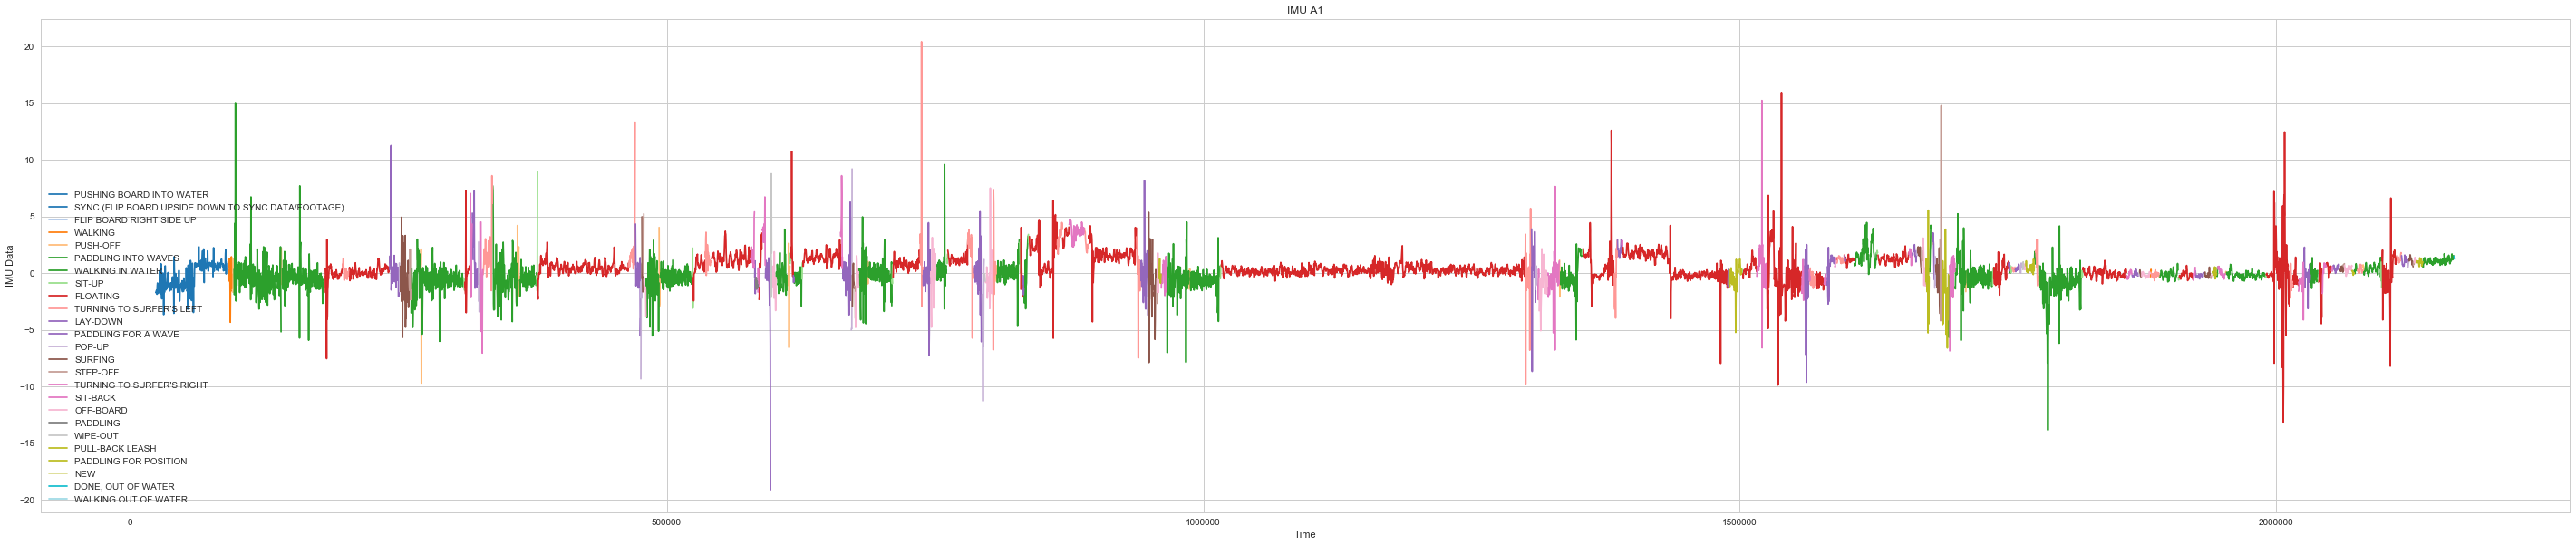

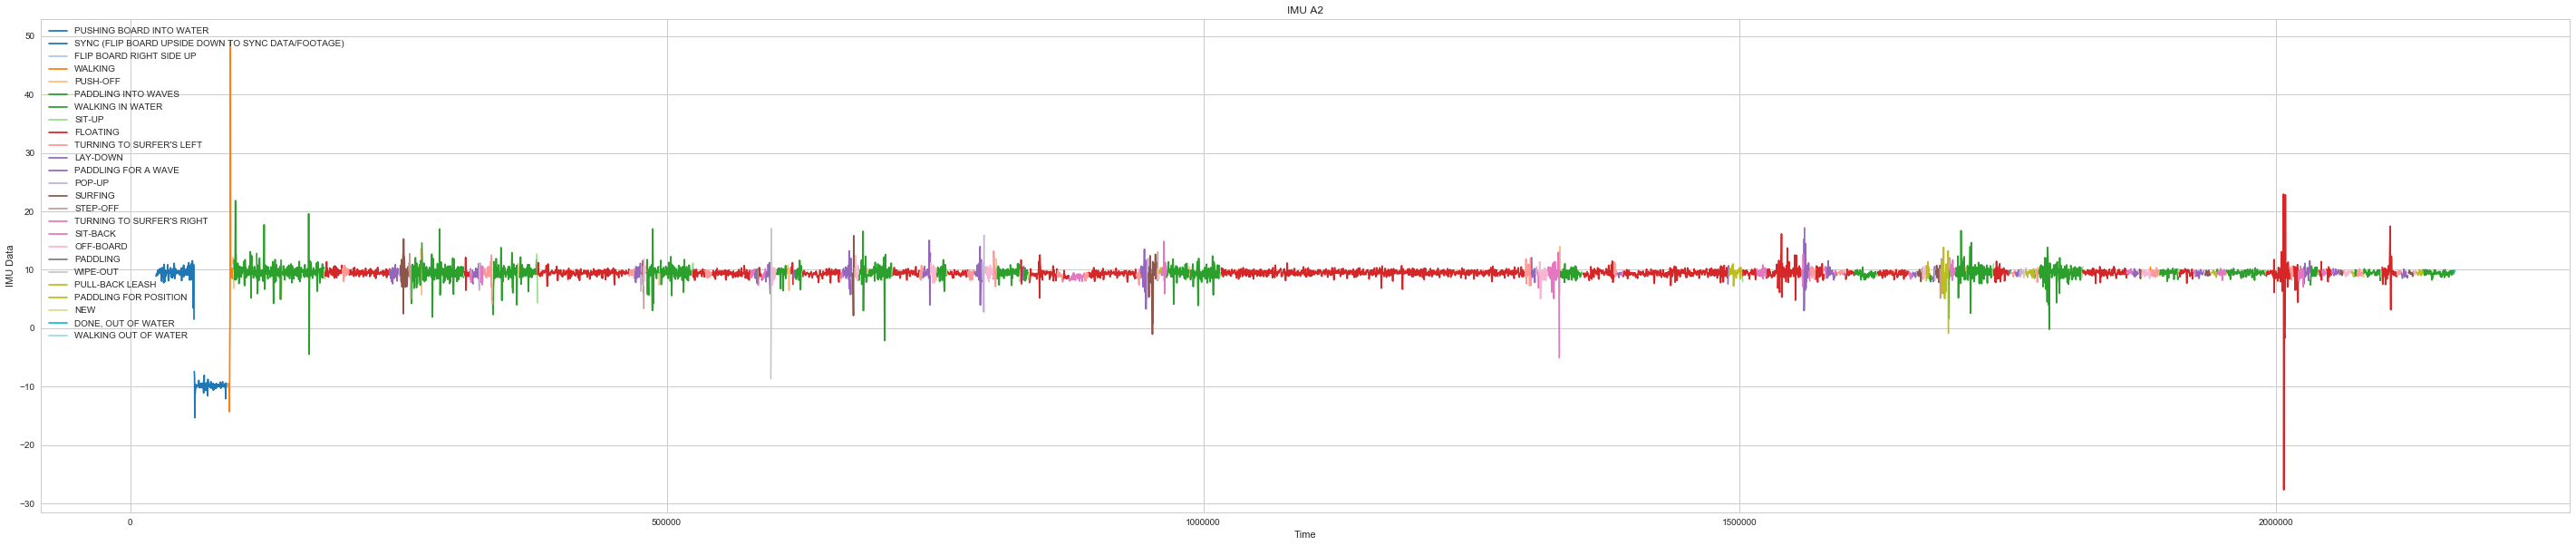

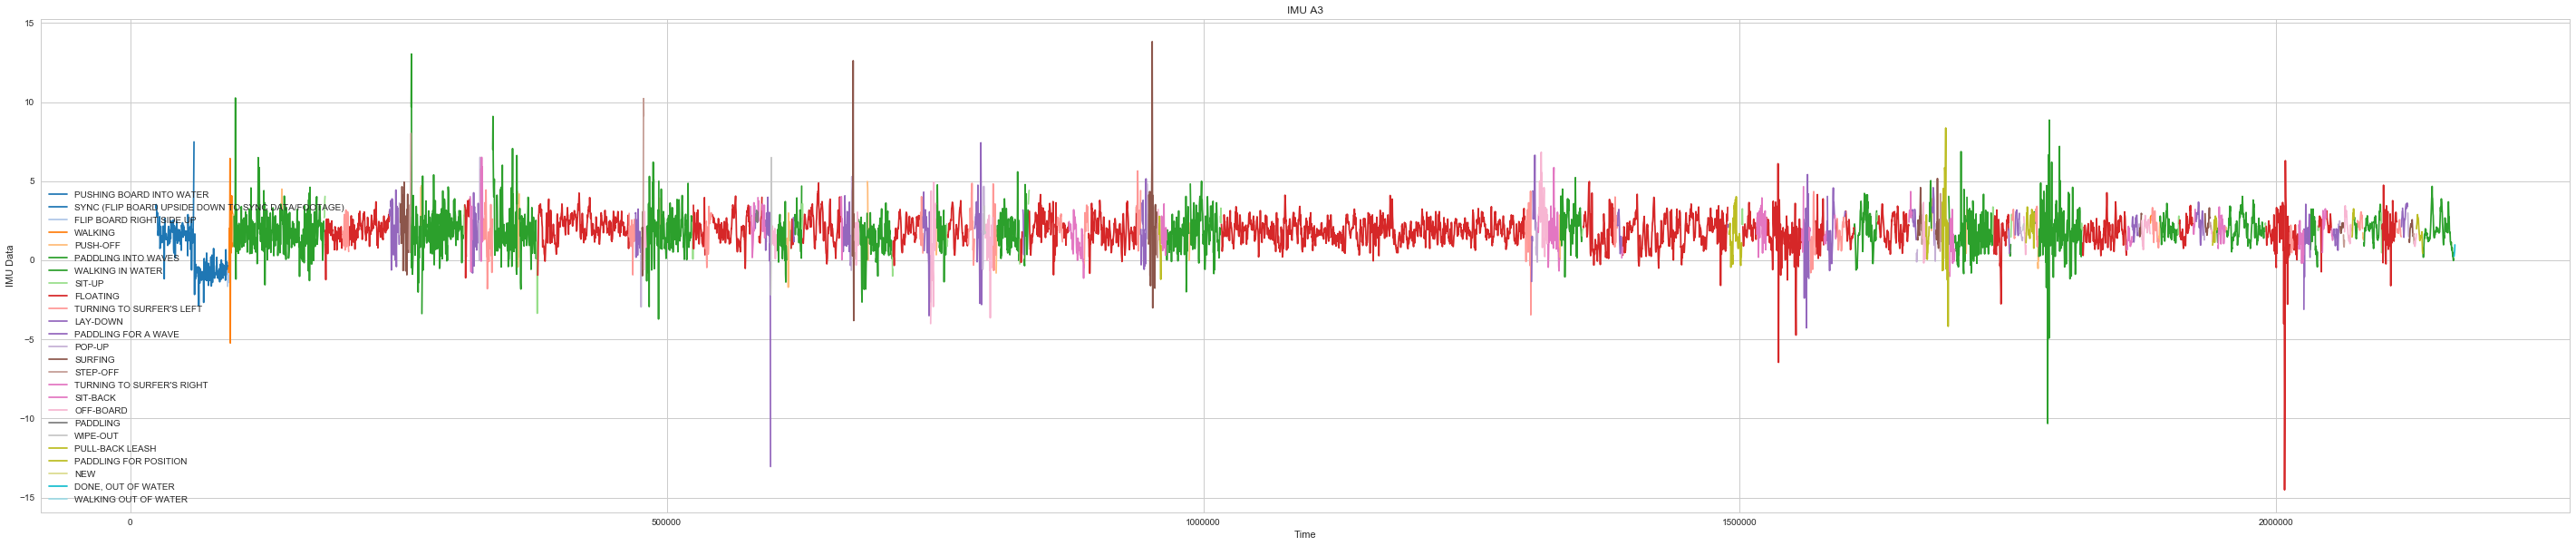

In [13]:
printf("Creating Plots")
createPlot(df_converted,'IMU A1')
createPlot(df_converted,'IMU A2')
createPlot(df_converted,'IMU A3')
#createPlot(df_converted,'IMU G1')
#createPlot(df_converted,'IMU G2')
#createPlot(df_converted,'IMU G3')
#createPlot(df_converted,'IMU M1')
#createPlot(df_converted,'IMU M2')
#createPlot(df_converted,'IMU M3')


## Butterworth Bandpass Filter

Plotting:


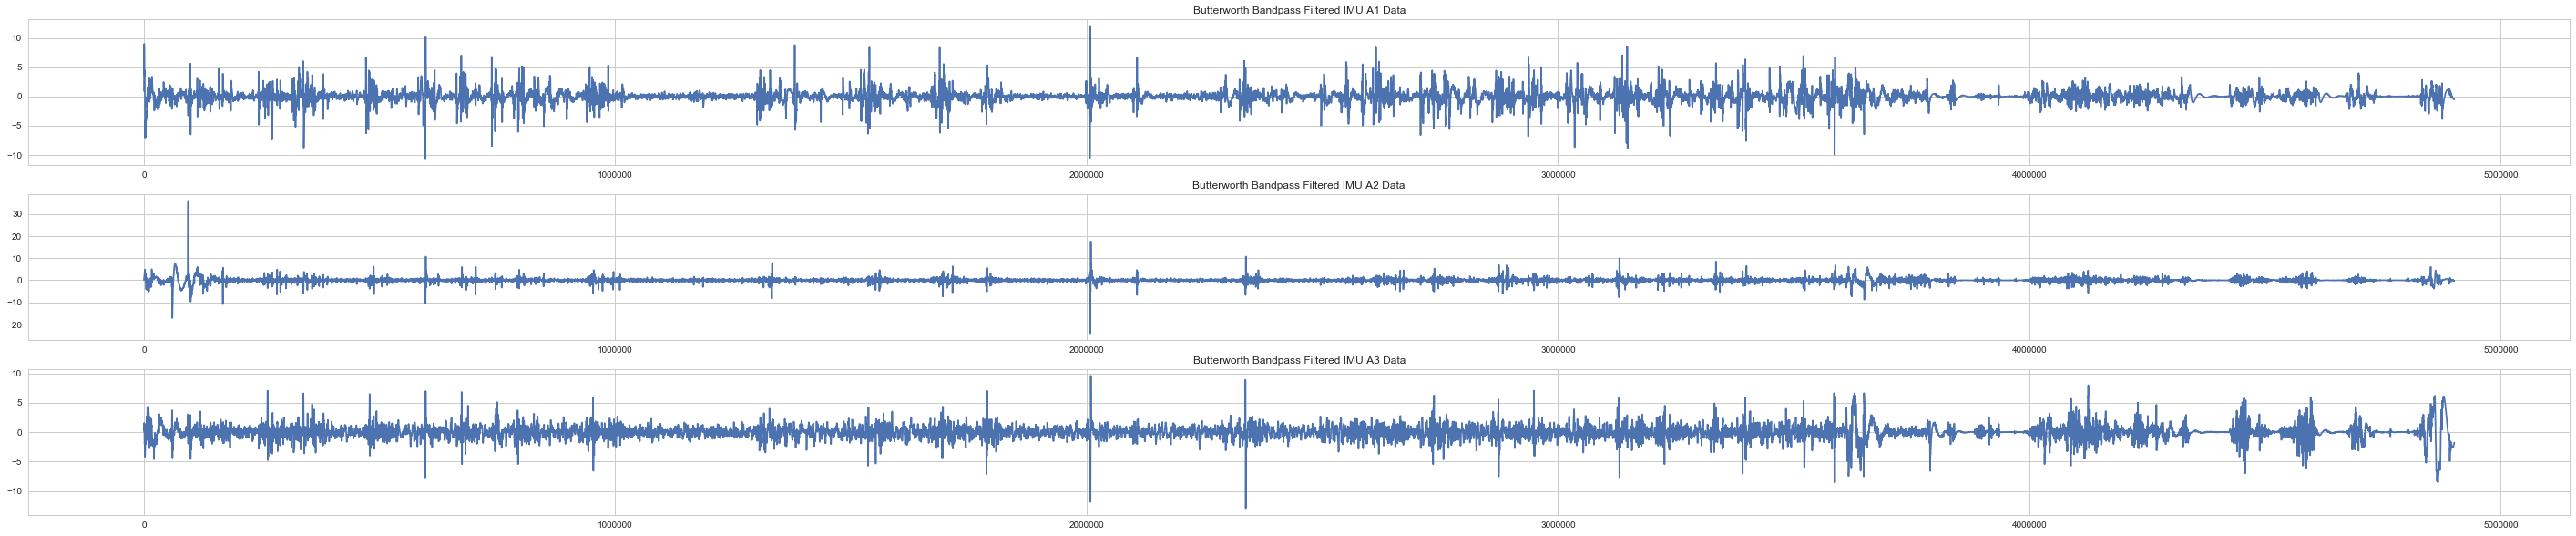

The plot for IMUA2 might be problematic because it truncates the sync step that happens in the beginning of the signal...


In [46]:
## Apply a Filter to the signals to reduce noise:
## Butter Filters for Bandpass:
from scipy import signal
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_lfilter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = signal.lfilter(b, a, data)
    return y

def butter_bandpass_filtfilt(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y



##Butter Filters for Highpass:
def butter_highpass(highcut, fs, order=5):
    nyq = 0.5 * fs
    high = highcut / nyq
    b, a = signal.butter(order, high, btype='high')
    return b, a

def butter_highpass_lfilter(data, highcut, fs, order=5):
    b, a = butter_lowpass(highcut, fs, order=order)
    y = signal.lfilter(b, a, data)
    return y



##Butter Filters for Lowpass:
def butter_lowpass(lowcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    b, a = signal.butter(order, low, btype='low')
    return b, a

def butter_lowpass_lfilter(data, lowcut, fs, order=5):
    b, a = butter_lowpass(lowcut, fs, order=order)
    y = signal.lfilter(b, a, data)
    return y




# Define the sample rate and the Low and High Cutoff frequencies
#fs = 30
fs = 5
lowcut = 0.0333
highcut = 1.5


#Get each IMU column from the dataframe: 
#array = df_converted.values

time_array = df_converted['TimeDelta'].values
imua1_array = df_converted['IMU A1'].values
imua2_array = df_converted['IMU A2'].values
imua3_array = df_converted['IMU A3'].values



##Graphing the bandpass filters:
#A bandpass filter is both a highpass and a lowpass filter combined.
butter_lfilter1 = butter_bandpass_lfilter(imua1_array, lowcut, highcut, fs, order=5)
butter_lfilter2 = butter_bandpass_lfilter(imua2_array, lowcut, highcut, fs, order=5)
butter_lfilter3 = butter_bandpass_lfilter(imua3_array, lowcut, highcut, fs, order=5)



#butter_filtfilt = butter_bandpass_filtfilt(dacc_array1, lowcut, highcut, fs, order=5)



#Can change num_elems to 1000 for example if you only want to graph the first 1000 elems:
num_elems = len(time_array)

print("Plotting:")
plt.figure(1)
plt.subplot(311)
plt.plot(time_array[:num_elems], butter_lfilter1[:num_elems])
plt.title("Butterworth Bandpass Filtered IMU A1 Data")

plt.subplot(312)
plt.plot(time_array[:num_elems], butter_lfilter2[:num_elems])
plt.title("Butterworth Bandpass Filtered IMU A2 Data")

plt.subplot(313)
plt.plot(time_array[:num_elems], butter_lfilter3[:num_elems])
plt.title("Butterworth Bandpass Filtered IMU A3 Data")

plt.show()

print("The plot for IMUA2 might be problematic because it truncates the sync step that happens in the beginning of the signal...")

In [ ]:
#Update cells with the filtered values: 

In [ ]:
#If we ever need to calculate averages from data rows/columns here's a link to do that:
#https://stackoverflow.com/questions/31698861/add-column-to-the-end-of-pandas-dataframe-containing-average-of-previous-data

